# Generating animated time series for the crop-mask  <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


## Description
This notebook:

1. Import a time series of cloud-free satellite imagery
2. Calculate annual geomedians
3. Open cropmask at the same location
4. Vectorize crop-mask for plotting over the animation
5. Create an animation

***

## Getting started

> Note: currently set up for running Landsat Collection 2 Provisional so requires setting `aws_unsigned=False` in the dask cluster creation and running it on a C2 sandbox 

### Load packages

In [1]:
%matplotlib inline

import sys
import datacube
import skimage.exposure
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import Image
import odc.algo
import xarray as xr
from datacube.utils import masking
from odc.algo import xr_geomedian, int_geomedian
from odc.algo import xr_reproject

sys.path.append('../Scripts')
from deafrica_plotting import xr_animation, rgb, display_map
from deafrica_datahandling import load_ard
from deafrica_dask import create_local_dask_cluster
from deafrica_spatialtools import xr_vectorize, xr_rasterize

In [2]:
create_local_dask_cluster(aws_unsigned=False)

Client Scheduler: tcp://127.0.0.1:36743 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


### Connect to the datacube

In [3]:
dc = datacube.Datacube(app='Animated_timeseries')

## Load satellite data from datacube


In [4]:
lat, lon = -8.105, 33.294 #-6.72, 32.214 #tanzania -6.7519, 32.4694
lon_buffer = 0.3
lat_buffer = 0.15

x = (lon-lon_buffer, lon+lon_buffer)
y =  (lat-lat_buffer, lat+lat_buffer)

# Create a reusable query
query = {
    'x': x,
    'y': y,
    'time': ('2013','2018'),
    'resolution': (-30, 30)
}

In [5]:
display_map(x=x, y=y)

In [6]:
# Load available data
ds = load_ard(dc=dc,
              products=['usgs_ls8c_level2_2'],
              measurements=['red', 'green', 'blue'], #'nir_1', 'swir_1', 'swir_2'
              group_by='solar_day',
              output_crs='epsg:6933',
              dask_chunks={'x':1000, 'y':1000},
              **query)

print(ds)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    usgs_ls8c_level2_2
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 254 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 254, x: 1931, y: 1264)
Coordinates:
  * time         (time) datetime64[ns] 2013-03-28T07:53:59.093111 ... 2018-12...
  * y            (y) float64 -1.012e+06 -1.012e+06 ... -1.05e+06 -1.05e+06
  * x            (x) float64 3.183e+06 3.183e+06 ... 3.241e+06 3.241e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


## Annual geomedians

In [7]:
grouped = ds.resample(time='1YS')
gms=grouped.map(xr_geomedian)
gms=gms.compute()

## Open crop-mask at same location

reproject to match Landsat

In [8]:
g_id='C-20'

In [9]:
p=xr.open_rasterio('../eastern_cropmask/results/classifications/predicted/20201215/Eastern_tile_'+g_id+'_prediction_pixel_gm_mads_two_seasons_20201215.tif')
p=p.squeeze().sel(x=slice(ds.coords['x'][0].values, ds.coords['x'][-1].values), y=slice(ds.coords['y'][0].values, ds.coords['y'][-1].values))

p=xr_reproject(p, gms.geobox, "nearest")
print(p)

<xarray.DataArray (y: 1264, x: 1931)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)
Coordinates:
  * y            (y) float64 -1.012e+06 -1.012e+06 ... -1.05e+06 -1.05e+06
  * x            (x) float64 3.183e+06 3.183e+06 ... 3.241e+06 3.241e+06
    spatial_ref  int32 6933


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


## Vectorize for plotting over satellite image

In [10]:
gdf = xr_vectorize(p,
                   crs=ds.crs,
                   transform=p.geobox.transform,
                   mask=p.values==1)

gdf['geometry'] = gdf['geometry'].buffer(0)
gdf['DISS_ID'] = 1
gdf = gdf.dissolve(by='DISS_ID', aggfunc='sum')

## Create animation

In [11]:
import numpy as np
import pandas as pd

recent = xr.concat([gms.isel(time=-1), gms.isel(time=-1)], dim='time')
time=pd.to_datetime(np.array(['2018-01-01', '2019-01-01']))
recent['time'] = time

Exporting animation to data/animations/tanzania_cropping.gif


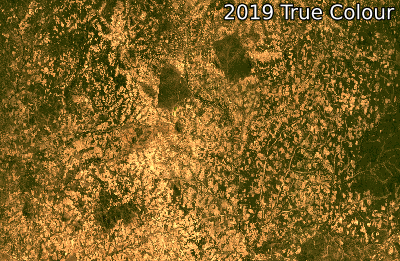

In [12]:
gdf['start_time'] = ['2019-01']
gdf['end_time'] = ['2019-01']

# Get shapefile path
gdf['color'] = '#3266ff90'

# Produce time series animation 
xr_animation(ds=recent,
             bands=['red', 'green', 'blue'],
             output_path='data/animations/tanzania_cropping.gif', 
             interval=1000, 
             width_pixels=400,
             show_date = None,
             show_text = ['2019 True Colour','2019 Crop Mask'],
             gdf_kwargs={'edgecolor': 'blue', 'linewidth':0.2},
             show_gdf=gdf) 

# Plot animated gif
plt.close()
Image(filename='data/animations/tanzania_cropping.gif')